## Fune-tune the System -SGD Classifier

In [1]:
# setting

import sys
sys.path.append("..")

from module.utils import general_utils
from module.utils import data_prepare_utils
from module.utils import model_performance_utils
import module.utils.bin_class_utils as bin_class_utils

from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
target_attr = "label"
target_type = "binary"

estimator_name = "SGDClassifier"

sample_random_state = 24
target_encoding_random_state = 42
loss = 'log_loss'
model_random_state = 42
permutation_importance_random_state = 0

In [3]:
train_df = pd.read_csv('train_df_exp.csv')
train_cap_x_df, train_y_df = train_df.drop(columns=target_attr), train_df[[target_attr]]

In [4]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_cap_x_df.columns if attr not in numerical_attr_list and attr != target_attr]
attr_list = numerical_attr_list + categorical_attr_list

In [5]:
attrs_to_drop = ['app_score', 'his_on_shelf_time', 'task_id', 'spread_app_id', 'tags', 'dev_id', 'app_second_class', 'adv_prim_id', 'device_price']
preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, attrs_to_drop, target_type, target_encoding_random_state)
estimator = SGDClassifier(loss=loss, random_state=model_random_state, class_weight=None)
dt_pipe = Pipeline([('preprocessor', preprocessor), ('estimator', estimator)])

#### 0. Tune Hyperparameters of Composite Estimator - Ranking Metrics

In [6]:
best_model = bin_class_utils.tune_hyperparameters_sgd(train_cap_x_df, train_y_df, dt_pipe)

Best estimator: {'estimator__alpha': 0.01, 'estimator__l1_ratio': 0.15, 'estimator__loss': 'log_loss', 'estimator__max_iter': 1000, 'estimator__n_jobs': None, 'estimator__penalty': 'l1', 'preprocessor__categorical__target_encoder__smooth': 'auto', 'preprocessor__numerical__imputer__strategy': 'mean'}


Check accuracy score
train set set accuracy score: 0.9655429594272077

Check confusion matrix
train set set confusion matrix: 
[[6473    0]
 [ 231    0]]
True Positives =  6473
True Negatives =  0
False Positives(Type I error) =  0
False Negatives(Type II error) =  231

Check classification report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      6473
           1       0.00      0.00      0.00       231

    accuracy                           0.97      6704
   macro avg       0.48      0.50      0.49      6704
weighted avg       0.93      0.97      0.95      6704


Check the ROC Curve and AUC


C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


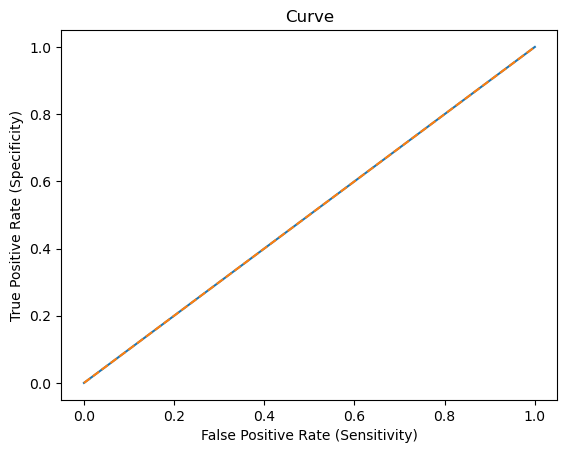


Check Precision-Recall Curve and Average Precision Score


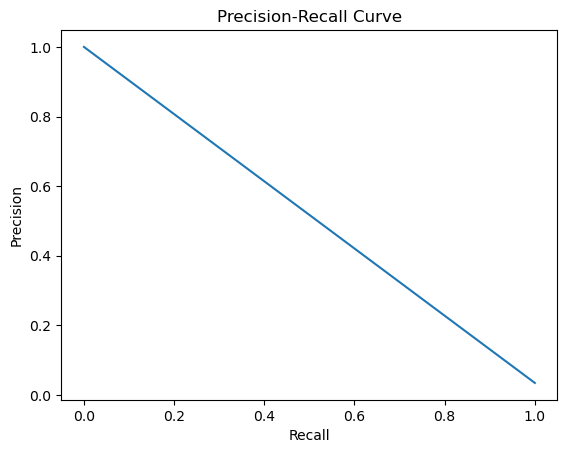

The roc_auc_score:  0.5
Average Precision Score:  0.03445704057279236


,class_weight_name,roc_curve_auc,ave_precision_score,data_set
0,None,0.5,0.034457,train


In [7]:
roc_auc, ave_precision = \
    bin_class_utils.eval_class(train_cap_x_df, train_y_df, best_model, 'train set')
dict_list = {
    'class_weight_name': 'None',
    'roc_curve_auc': roc_auc,
    'ave_precision_score': ave_precision,
    'data_set': 'train'
}
perf_dict_df = pd.DataFrame([dict_list])
perf_dict_df

#### 1. Evaluate Tuned Composite Estimators

In [9]:
validation_df = pd.read_csv('validation_df_exp.csv')
validation_cap_x_df, validation_y_df = validation_df.drop(columns=target_attr), validation_df[[target_attr]]

Check accuracy score
validation set accuracy score: 0.9683770883054893

Check confusion matrix
validation set confusion matrix: 
[[1617    1]
 [  52    6]]
True Positives =  1617
True Negatives =  6
False Positives(Type I error) =  1
False Negatives(Type II error) =  52

Check classification report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1618
           1       0.86      0.10      0.18        58

    accuracy                           0.97      1676
   macro avg       0.91      0.55      0.58      1676
weighted avg       0.96      0.97      0.96      1676


Check the ROC Curve and AUC


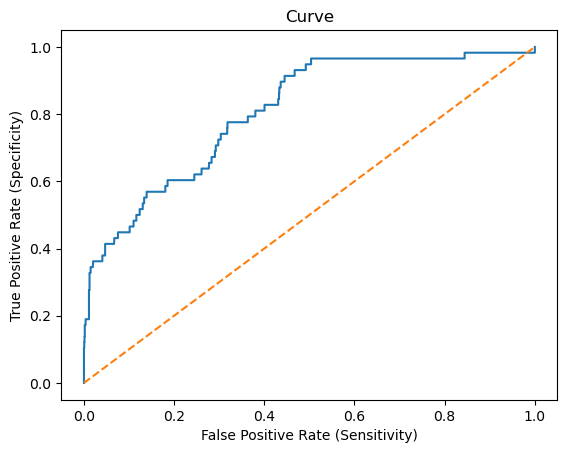


Check Precision-Recall Curve and Average Precision Score


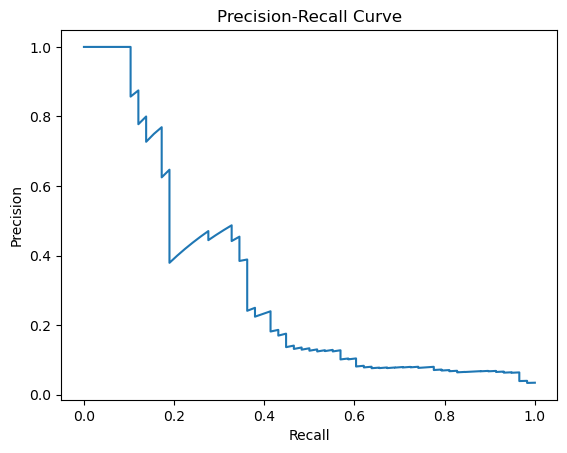

The roc_auc_score:  0.5514151144452496
Average Precision Score:  0.3125069792000023


,class_weight_name,roc_curve_auc,ave_precision_score,data_set
0,None,0.551415,0.312507,validation


In [10]:
val_roc_auc, val_ave_precision = \
    bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, best_model, 'validation')
val_dict_list = {
    'class_weight_name': 'None',
    'roc_curve_auc': val_roc_auc,
    'ave_precision_score': val_ave_precision,
    'data_set': 'validation'
}
val_perf_dict_df = pd.DataFrame([val_dict_list])
val_perf_dict_df

In [11]:
# compare the performance on the train and validation set
pd.concat([perf_dict_df, val_perf_dict_df], ignore_index=True)

,class_weight_name,roc_curve_auc,ave_precision_score,data_set
0,None,0.500000,0.034457,train
1,None,0.551415,0.312507,validation


#### 2. Calibrate Composite Estimator If Required

#### 3. Check for False Discoveries


**************************************************
means of the distributions:
                          ave_precision_score
distribution                                 
bootstrap_sample                     0.618448
randomized_target_sample             0.035980


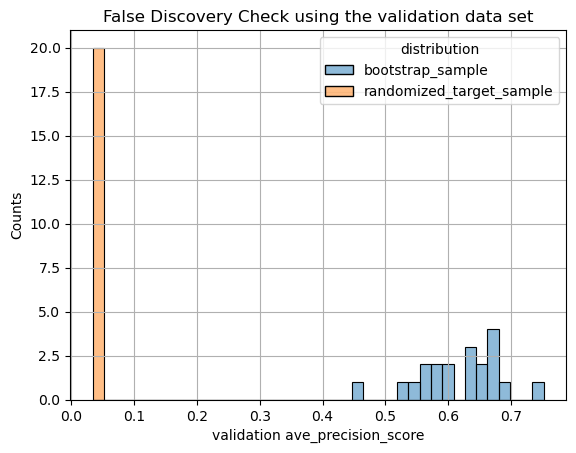


**************************************************
means of the distributions:
                          roc_auc_score_
distribution                            
bootstrap_sample                0.882537
randomized_target_sample        0.513869


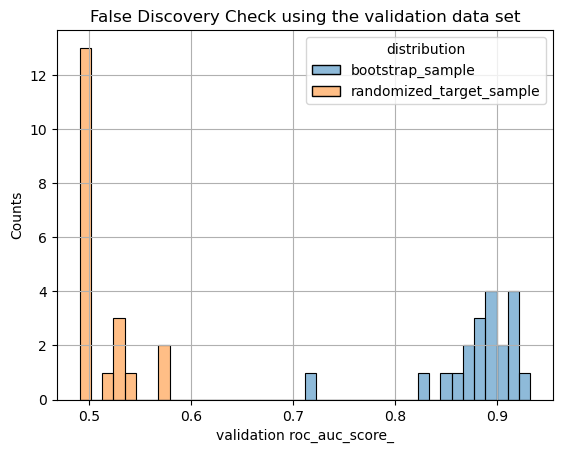

In [12]:
bin_class_utils.avoiding_false_discoveries(best_model, train_cap_x_df, train_y_df, validation_cap_x_df,
                                            validation_y_df, num_samples=20, data_type='validation')

#### 4. Selection a Model

#### 5. Permutation Feature Importance

In [13]:
permutation_df_ave_pre = bin_class_utils.print_permutation_importance_all(
    best_model, 
    train_cap_x_df, 
    train_y_df, 
    permutation_importance_random_state,
    'average_precision'
)

permutation_df_ave_pre


Permutation importance:


In [14]:
permutation_df_roc = bin_class_utils.print_permutation_importance_all(
    best_model, 
    train_cap_x_df, 
    train_y_df, 
    permutation_importance_random_state,
    'roc_auc'
)

permutation_df_roc


Permutation importance:


#### 6. Tune Classification Threshold for Classification - Classification Metrics

In [16]:
thresholds = np.arange(0, 0.1, 0.01)

bin_class_utils.print_classification_metrics_at_thresholds(best_model, validation_cap_x_df, validation_y_df, thresholds)


Classification Report at Threshold 0.00:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1618
           1       0.03      1.00      0.07        58

    accuracy                           0.03      1676
   macro avg       0.02      0.50      0.03      1676
weighted avg       0.00      0.03      0.00      1676


Classification Report at Threshold 0.01:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1618
           1       0.03      1.00      0.07        58

    accuracy                           0.03      1676
   macro avg       0.02      0.50      0.03      1676
weighted avg       0.00      0.03      0.00      1676


Classification Report at Threshold 0.02:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1618
           1       0.03      1.00      0.07        58

    accuracy                           0.03      1676

C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\P


Classification Report at Threshold 0.04:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1618
           1       0.00      0.00      0.00        58

    accuracy                           0.97      1676
   macro avg       0.48      0.50      0.49      1676
weighted avg       0.93      0.97      0.95      1676


Classification Report at Threshold 0.05:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1618
           1       0.00      0.00      0.00        58

    accuracy                           0.97      1676
   macro avg       0.48      0.50      0.49      1676
weighted avg       0.93      0.97      0.95      1676


Classification Report at Threshold 0.06:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1618
           1       0.00      0.00      0.00        58

    accuracy                           0.97      1676

C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\P

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1618
           1       0.00      0.00      0.00        58

    accuracy                           0.97      1676
   macro avg       0.48      0.50      0.49      1676
weighted avg       0.93      0.97      0.95      1676


Classification Report at Threshold 0.09:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1618
           1       0.00      0.00      0.00        58

    accuracy                           0.97      1676
   macro avg       0.48      0.50      0.49      1676
weighted avg       0.93      0.97      0.95      1676



C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\P

#### 7. Serialize Model and Classification Threshold

#### 8. Evaluate Model on the Test Set